In [1]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from datetime import datetime, date
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split - not applicable for timeseries data




from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss

from itertools import product                    # some useful functions
from tqdm.notebook import tqdm




In [2]:
# Load data

WI2 = pd.read_excel('C:/Users/danie/Documents/Data Science/Institute of Data/Capstone Project/storeWI2new.xlsx',index_col=0)
WI2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1913 entries, 2011-01-29 to 2016-04-24
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   vol           1913 non-null   int64  
 1   sell_price_s  1913 non-null   float64
 2   sell_price    1913 non-null   float64
 3   snap_WI       1913 non-null   int64  
 4   event1        1913 non-null   int64  
 5   Xmas          1913 non-null   int64  
 6   TG            1913 non-null   int64  
 7   NY            1913 non-null   int64  
 8   LD            1913 non-null   int64  
 9   SB            1913 non-null   int64  
 10  eve           1913 non-null   int64  
dtypes: float64(2), int64(9)
memory usage: 179.3 KB


In [3]:
WI2.rename(columns={'vol':'WI_2'},inplace=True)

In [4]:
WI2.head(10)

,WI_2,sell_price_s,sell_price,snap_WI,event1,Xmas,TG,NY,LD,SB,eve
date,,,,,,,,,,,
2011-01-29,2256,3667.12,1.202729,0,0,0,0,0,0,0,0
2011-01-30,1922,3667.12,1.202729,0,0,0,0,0,0,0,0
2011-01-31,2018,3667.12,1.202729,0,0,0,0,0,0,0,0
2011-02-01,2522,3667.12,1.202729,0,0,0,0,0,0,0,0
2011-02-02,1175,3667.12,1.202729,1,0,0,0,0,0,0,0
2011-02-03,2244,3667.12,1.202729,1,0,0,0,0,0,0,0
2011-02-04,2232,3667.12,1.202729,0,0,0,0,0,0,0,0
2011-02-05,2643,4337.92,1.422735,1,0,0,0,0,0,0,1
2011-02-06,2140,4337.92,1.422735,1,1,0,0,0,0,1,0


WI2sub = WI2.loc['2012-06':]
WI2sub.info()

##### create exog variables

In [5]:
exog = WI2[['sell_price','snap_WI','Xmas','TG', 'NY', 'LD', 'SB','eve']]
exog.shape

(1913, 8)

In [6]:
WI2.WI_2['2016-04-24']

5127

##### create exog forecast variables - sell price and snap event

In [7]:
# load dataset - spWI2
spWI2 = pd.read_excel('C:/Users/danie/Documents/Data Science/Institute of Data/Capstone Project/sp_mean_WI2.xlsx', index_col=0)

In [8]:
spWI2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1969 entries, 2011-01-29 to 2016-06-19
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sell_price  1969 non-null   float64
dtypes: float64(1)
memory usage: 30.8 KB


In [9]:
spWI2.index.is_all_dates

True

In [10]:
exog1 = spWI2[['sell_price']]
exog1

,sell_price
date,
2011-01-29,4.143638
2011-01-30,4.143638
2011-01-31,4.143638
2011-02-01,4.143638
2011-02-02,4.143638
...,...
2016-06-15,4.495044
2016-06-16,4.495044
2016-06-17,4.495044


In [11]:
# Load data - calendar
cal = pd.read_excel('C:/Users/danie/Documents/Data Science/Institute of Data/Capstone Project/cal_det.xlsx', index_col=0)
cal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1969 entries, d_1 to d_1969
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   event_name_1  1969 non-null   object
 7   event_type_1  1969 non-null   object
 8   event_name_2  1969 non-null   object
 9   event_type_2  1969 non-null   object
 10  snap_CA       1969 non-null   int64 
 11  snap_TX       1969 non-null   int64 
 12  snap_WI       1969 non-null   int64 
 13  yrmth         1969 non-null   object
 14  event1        1969 non-null   int64 
 15  event2        1969 non-null   int64 
 16  events        1969 non-null   int64 
 17  is_eventR     1969 non-null   int64 
 18  is_eventN     1969 non-null   int64 
 19  is_even

In [12]:
cal.reset_index()
#cal.index.astype('datetime64[ns]')

,int_day,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,...,is_eventR,is_eventN,is_eventC,is_eventS,Xmas,TG,NY,LD,SB,eve
0,d_1,2011-01-29,11101,Saturday,1,1,2011,nil,nil,nil,...,0,0,0,0,0,0,0,0,0,0
1,d_2,2011-01-30,11101,Sunday,2,1,2011,nil,nil,nil,...,0,0,0,0,0,0,0,0,0,0
2,d_3,2011-01-31,11101,Monday,3,1,2011,nil,nil,nil,...,0,0,0,0,0,0,0,0,0,0
3,d_4,2011-02-01,11101,Tuesday,4,2,2011,nil,nil,nil,...,0,0,0,0,0,0,0,0,0,0
4,d_5,2011-02-02,11101,Wednesday,5,2,2011,nil,nil,nil,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,d_1965,2016-06-15,11620,Wednesday,5,6,2016,nil,nil,nil,...,0,0,0,0,0,0,0,0,0,0
1965,d_1966,2016-06-16,11620,Thursday,6,6,2016,nil,nil,nil,...,0,0,0,0,0,0,0,0,0,0
1966,d_1967,2016-06-17,11620,Friday,7,6,2016,nil,nil,nil,...,0,0,0,0,0,0,0,0,0,0
1967,d_1968,2016-06-18,11621,Saturday,1,6,2016,nil,nil,nil,...,0,0,0,0,0,0,0,0,0,1


In [13]:
cal.set_index('date', inplace=True)


In [14]:
cal.index = pd.to_datetime(cal.index)
cal.index.is_all_dates

True

In [15]:
cal.shape

(1969, 26)

In [16]:
exog2 = cal[['snap_WI','Xmas','TG', 'NY', 'LD', 'SB','eve']]

In [17]:
exogtmp = exog1.join(exog2)

In [18]:
exogtmp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1969 entries, 2011-01-29 to 2016-06-19
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sell_price  1969 non-null   float64
 1   snap_WI     1969 non-null   int64  
 2   Xmas        1969 non-null   int64  
 3   TG          1969 non-null   int64  
 4   NY          1969 non-null   int64  
 5   LD          1969 non-null   int64  
 6   SB          1969 non-null   int64  
 7   eve         1969 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 218.4 KB


In [19]:
exog_F = exogtmp[exogtmp.shape[0]-56:exogtmp.shape[0]-56+51]

In [20]:
exog_F.shape

(51, 8)

#### WI2 timeseries

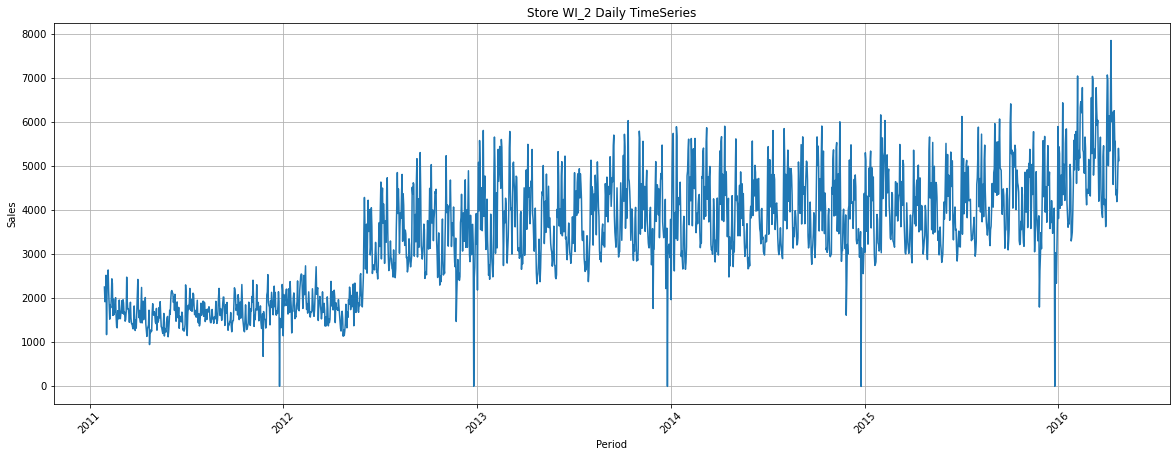

In [21]:
plt.figure(figsize=(20, 7))
plt.plot(WI2.WI_2)
plt.title('Store WI_2 Daily TimeSeries')
plt.xlabel('Period')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.grid()
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

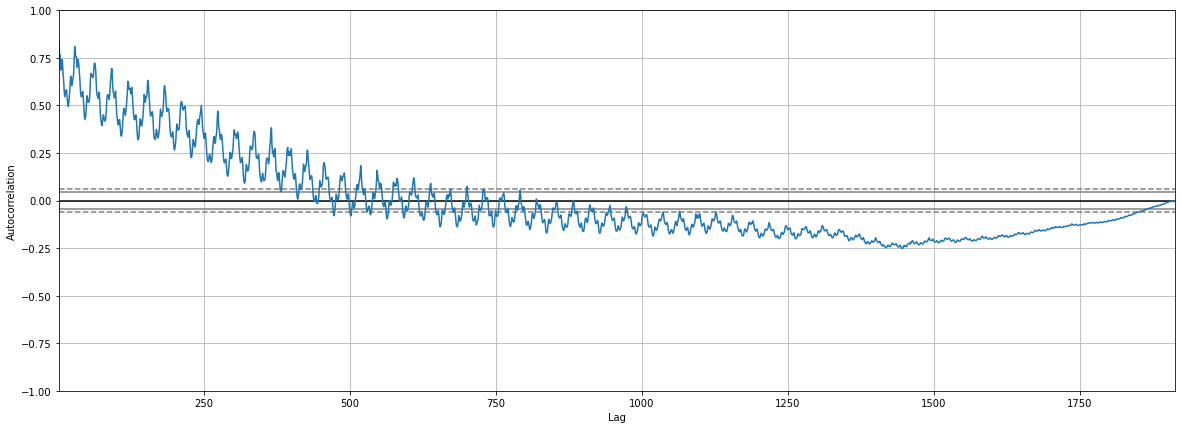

In [22]:
plt.figure(figsize=(20, 7))
pd.plotting.autocorrelation_plot(WI2.WI_2) 

#The horizontal lines in the plot correspond to 95% and 99% confidence bands.
#The dashed line is 99% confidence band


# link : 
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/#:~:text=ARIMA%20with%20Python&text=Define%20the%20model%20by%20calling,or%20times%20to%20be%20predicted
# eg There is a positive correlation with the first 8 lags that is perhaps significant for the first 5 lags (literally following eg).
# eg A good starting point for the AR parameter of the model may be 5.

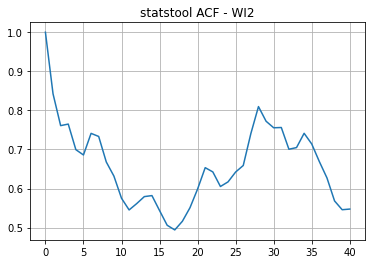

In [23]:
# use statstool to plot acf ie statsmodels.tsa.stattools.acf

plt.plot(acf(WI2.WI_2, fft=True))
plt.grid()
plt.title('statstool ACF - WI2')
plt.show()

# Looks a positive correlation with the 5th - 6th lags (daily timeseries started on Sat)

### SARIMA with Exogenuous Variables

#### Getting rid of non-stationarity and building SARIMA (topic 9 part 1 timeseries nb)

In [24]:
#Let's build an ARIMA model by walking through all the circles of hell stages of making a series stationary.
#Here is the code to render plots.

def tsplot(y, lags=None, figsize=(15, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, fft= True)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method='ywm') # “ywm” or “ywmle” : Yule-Walker without adjustment.
        plt.tight_layout()


        
# The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root 
# and is non-stationary. So, if the P-Value in ADH test is less than the significance level (0.05), 
# you reject the null hypothesis.        


# The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, 
# with the alternative that there is no unit root. If the pvalue is above a critical size, 
# then we cannot reject that there is a unit root.

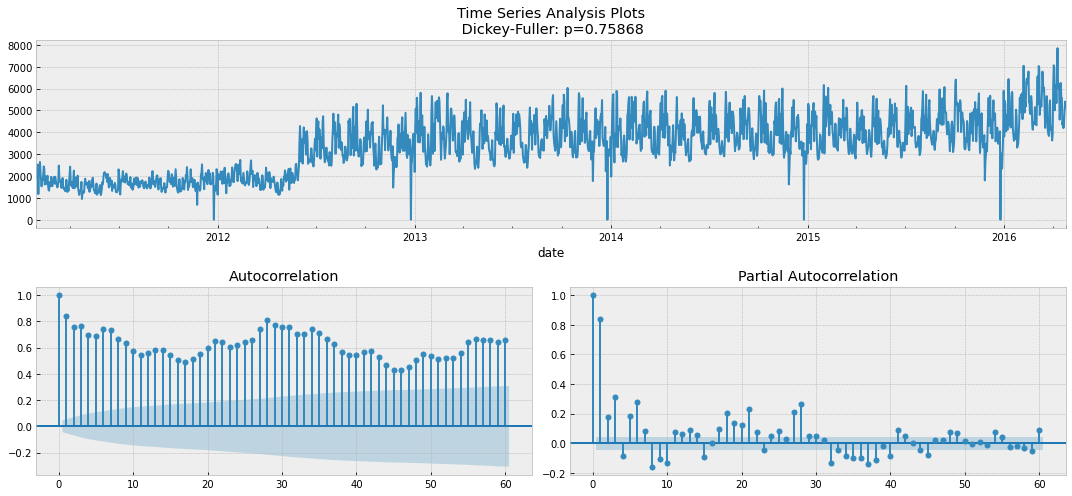

In [25]:
tsplot(WI2.WI_2, lags=60) 

# null hypothesis is established, hence there is non-stationarity

In [26]:
# ADF Test
result = adfuller(WI2.WI_2, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# When the test statistic is lower than the critical value shown, 
# you reject the null hypothesis and infer that the time series is stationary.

ADF Statistic: -0.9850342211374304
p-value: 0.7586835148120399
Critial Values:
   1%, -3.433822016251123
Critial Values:
   5%, -2.8630736989499335
Critial Values:
   10%, -2.567586484303047


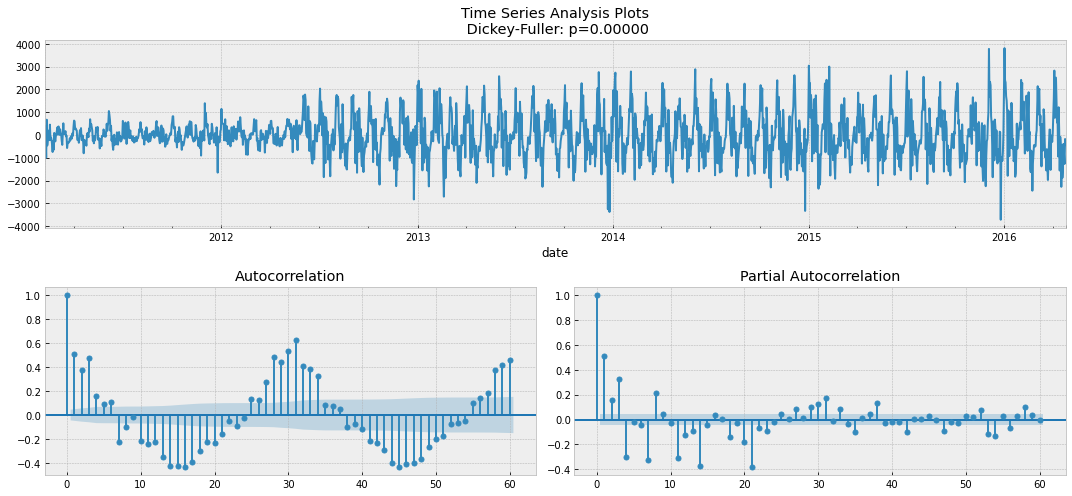

In [27]:
# make a time series stationary
# order of differencing 1
x = pd.Series(WI2.WI_2)
x_diff = x - x.shift(7)
tsplot(x_diff[7:], lags=60) 


In [28]:
# ADF Test
result = adfuller(x_diff[7:], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

    
# When the test statistic is lower than the critical value shown, 
# you reject the null hypothesis and infer that the time series is stationary.
# Once passed the ADF test, the time series is stationary. No further differencing is required.

ADF Statistic: -14.53307299793473
p-value: 5.292688157232514e-27
Critial Values:
   1%, -3.4338349685861806
Critial Values:
   5%, -2.8630794170659684
Critial Values:
   10%, -2.5675895289750503


In [29]:
## at 1st order of differencing, no visible trend, ie mean is constant and the variance is pretty much stable. 
## The only thing left is seasonality, which we have to deal with prior to modeling. 
## To do so, let's take the "seasonal difference", which means a simple subtraction of the series from itself 
## with a lag that equals the seasonal period.

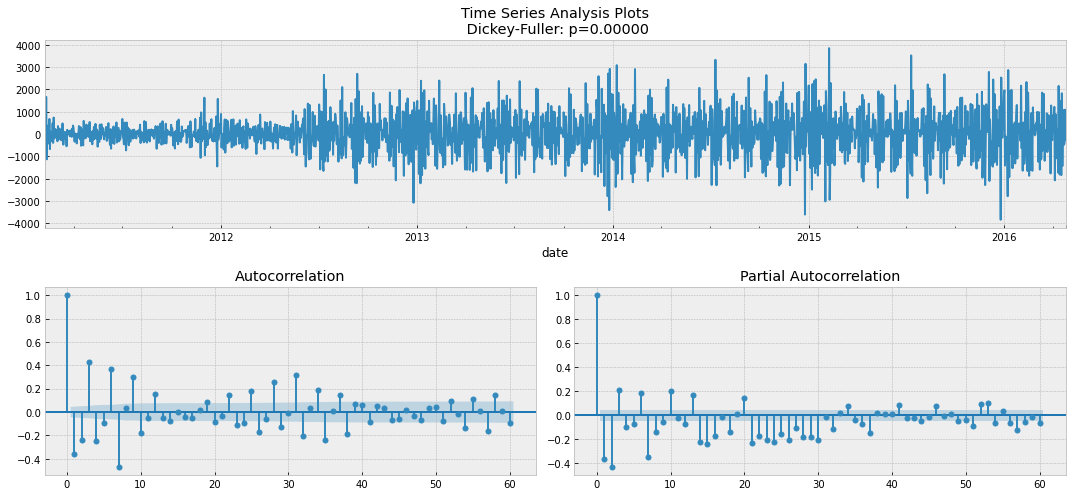

In [30]:
# order of differencing 2
x_diff = x_diff - x_diff.shift(1)
tsplot(x_diff[7+1:], lags=60)

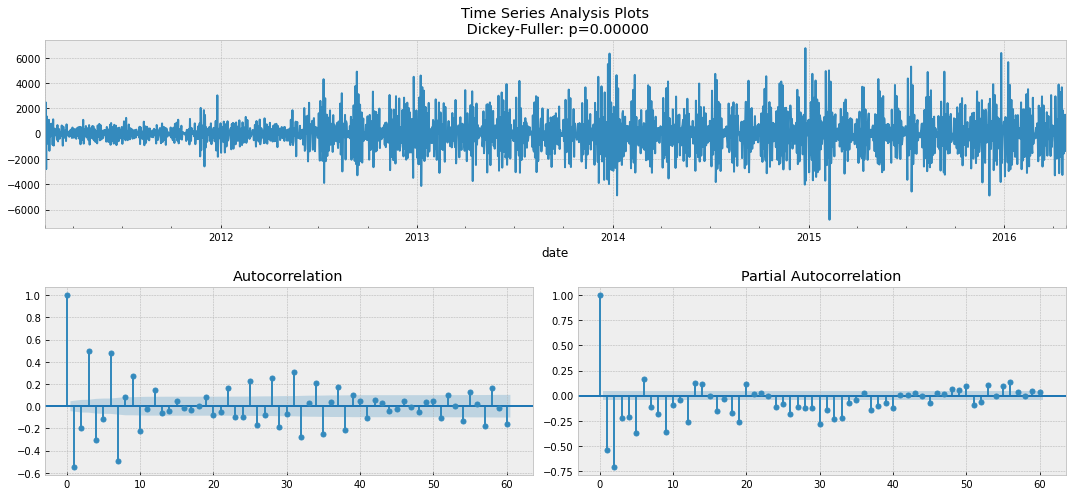

In [55]:
# order of differencing 3
x_diff = x_diff - x_diff.shift(1)
tsplot(x_diff[7+1+1:], lags=60)

In [31]:
# setting initial values and some bounds for them
ps = range(1, 3)
d=1 
qs = range(1, 3)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 7 # season length is 7 days

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [32]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(WI2.WI_2, exog=exog, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table



In [33]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

C:\Users\danie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\danie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\danie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\danie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\danie\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Us

C:\Users\danie\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



Wall time: 3min 4s


In [34]:
result_table.head()

,parameters,aic
0,"(1, 2, 1, 1)",28367.035080
1,"(1, 2, 0, 1)",28367.527903
2,"(2, 1, 1, 1)",28398.626887
3,"(1, 1, 1, 1)",28403.797032
4,"(1, 1, 0, 1)",28404.230535


In [67]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[2]

#p = 1
#q = 1
#P = 0
#Q =0
#s = 7
#d = 1
#D = 1

best_model=sm.tsa.statespace.SARIMAX(WI2.WI_2, exog=exog, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())



C:\Users\danie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\danie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\danie\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                     SARIMAX Results                                     
Dep. Variable:                              WI_2   No. Observations:                 1913
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -14185.313
Date:                           Thu, 08 Oct 2020   AIC                          28398.627
Time:                                   16:25:19   BIC                          28476.358
Sample:                               01-29-2011   HQIC                         28427.239
                                    - 04-24-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sell_price -1264.4946    682.897     -1.852      0.064   -2602.947      73.958
snap_WI      688.1211     19.885     34.605

In [60]:
### Inspect the residuals of the model

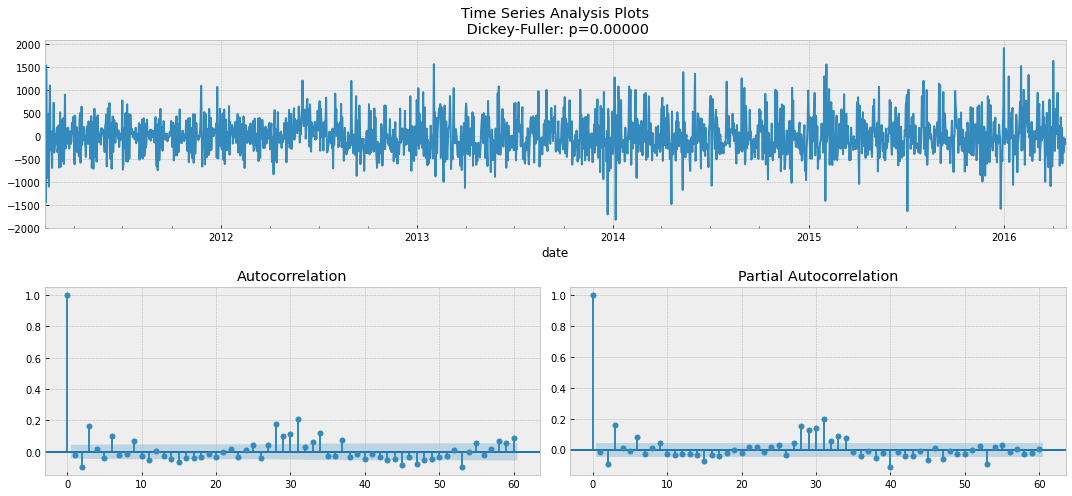

In [68]:
tsplot(best_model.resid[7+1:], lags=60) 


In [69]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [70]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual','sell_price_s','sell_price', 'snap_WI','event1', 'Xmas', 'TG', 'NY', 'LD', 'SB','eve']
    data['arima_model'] = model.fittedvalues
    
    xmas = pd.to_datetime(['2011-12-25','2012-12-25','2013-12-25','2014-12-25','2015-12-25','2016-12-25'])

    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN

    # overwrite data.arima_model for X'mas day with 0 sales
    for i in range(len(data)) :
        if data.index[i] in xmas :
            data.arima_model[i] = 0
        else :
            pass
    
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps, exog=exog_F)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    mse_score = mean_squared_error(data['actual'][s+d:], data['arima_model'][s+d:])
    print('mse : ', mse_score)
    
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);
    
    pred_table = pd.DataFrame(forecast)
    pred_table.columns = ['Predictions']
    
    return pred_table, error, mse_score


mse :  170154.30043770804


C:\Users\danie\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\danie\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\danie\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


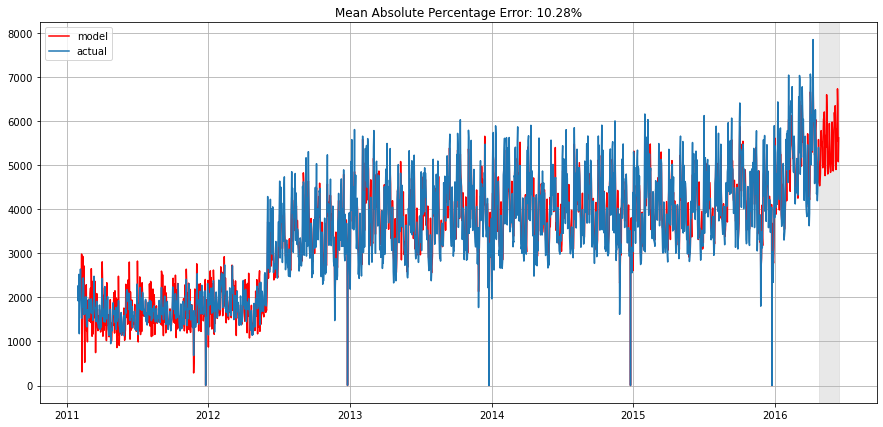

In [71]:
pred_table, err, mse = plotSARIMA(WI2, best_model, 50)
# mean absolute percentage error = inf% due to numpy

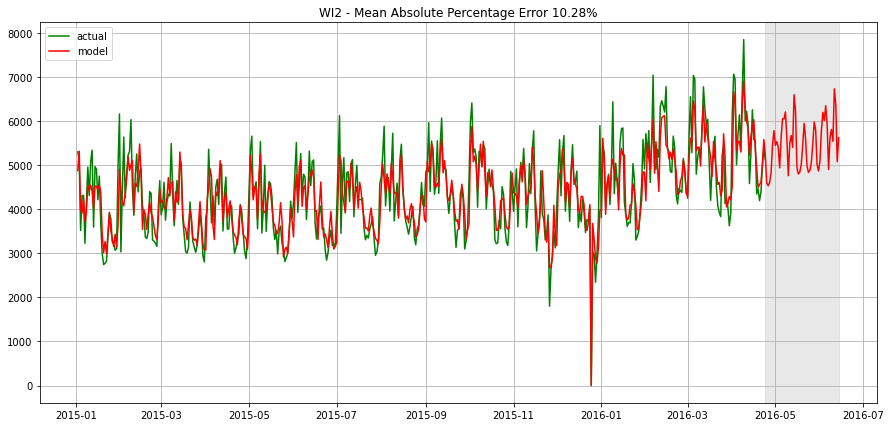

In [72]:
plt.figure(figsize=(15, 7))
plt.title("WI2 - Mean Absolute Percentage Error {0:.2f}%".format(err))
plt.plot(WI2.WI_2[1434:], color='g', label="actual")
plt.plot(pred_table[1434:], color='r', label="model")
plt.axvspan(WI2.index[-1], pred_table.index[-1], alpha=0.5, color='lightgrey')
plt.legend()
plt.grid(True);

In [73]:
pred_table.to_excel('predWIF7new.xlsx')

In [74]:
WI2.index[-1]

Timestamp('2016-04-24 00:00:00')

###### Evaluate predictions with provided evaluation dataset

In [75]:
eData = pd.read_excel('C:/Users/danie/Documents/Data Science/Institute of Data/Capstone Project/eWI2.xlsx', index_col = 0)

In [76]:
eData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1941 entries, 2011-01-29 to 2016-05-22
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   WI_2          1941 non-null   int64 
 1   wm_yr_wk      1941 non-null   int64 
 2   weekday       1941 non-null   object
 3   wday          1941 non-null   int64 
 4   month         1941 non-null   int64 
 5   year          1941 non-null   int64 
 6   event_name_1  1941 non-null   object
 7   event_type_1  1941 non-null   object
 8   event_name_2  1941 non-null   object
 9   event_type_2  1941 non-null   object
 10  snap_WI       1941 non-null   int64 
 11  yrmth         1941 non-null   object
 12  event1        1941 non-null   int64 
 13  event2        1941 non-null   int64 
 14  events        1941 non-null   int64 
 15  is_eventR     1941 non-null   int64 
 16  is_eventN     1941 non-null   int64 
 17  is_eventC     1941 non-null   int64 
 18  is_eventS     1941 non-null   

In [77]:
eval_tbl = eData[['WI_2']]

In [78]:
pred = pred_table[:1941]

In [79]:
pred.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1941 entries, 2011-01-29 to 2016-05-22
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Predictions  1933 non-null   float64
dtypes: float64(1)
memory usage: 30.3 KB


In [80]:
mse_eval = mean_squared_error(eval_tbl.WI_2[7+1:], pred.Predictions[7+1:])
mse_eval

173712.19451624688

In [81]:
err_eval =  mean_absolute_percentage_error(eval_tbl.WI_2[7+1:], pred.Predictions[7+1:])
err_eval

10.259597868909703

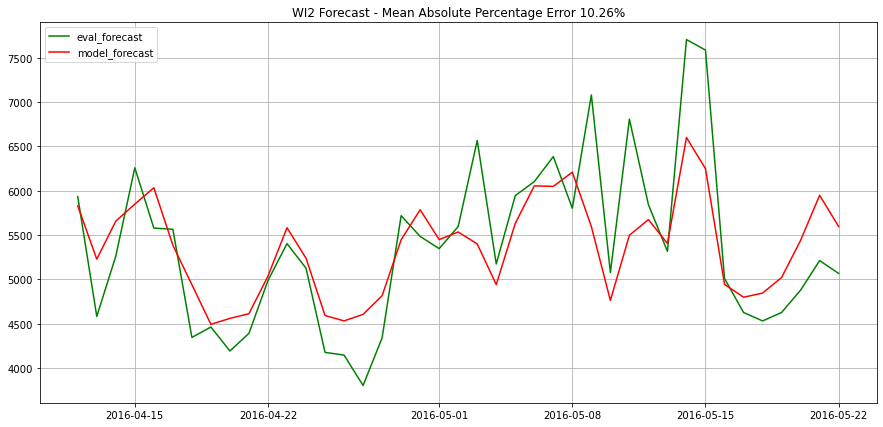

In [82]:
plt.figure(figsize=(15, 7))
plt.title("WI2 Forecast - Mean Absolute Percentage Error {0:.2f}%".format(err_eval))
plt.plot(eval_tbl.WI_2[1900:], color='g', label="eval_forecast")
plt.plot(pred.Predictions[1900:], color='r', label="model_forecast")
plt.axvspan(eval_tbl.index[-1], pred.index[-1], alpha=0.5, color='lightgrey')
plt.legend()
plt.grid(True);